# SCINet

코인의 변화량은 계절, 날짜, 시간대 등에서 큰 영향력을 가지고 있지 않다.  
미래에 대한 알고있는 정보들 중에 쓰일만한 정보는 없다고 본다.  
  
다변량 시계열 데이터의 SOTA인 TFT 보다 단변량 시계열에서 우수한 SCINet을 적용한다. 

![SCINet_ARC](SCINet_arc.png)

⊙ : hadamard product (아다마르 곱 : 두 행렬의 각 원소의 곱).mul  
ψ,ϕ,η,ρ : 각각의 1d cnn  

In [1]:
import numpy as np
import pandas as pd
import time

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('./data/BTC-M.csv',parse_dates=[0], index_col=[0])
df.drop('value',axis=1, inplace=True)
df.head(3)

,open,high,low,close,volume
2018-09-19 23:50:00,7180000.0,7187000.0,7180000.0,7187000.0,0.504830
2018-09-19 23:51:00,7186000.0,7188000.0,7181000.0,7181000.0,0.882076
2018-09-19 23:52:00,7184000.0,7188000.0,7183000.0,7188000.0,0.486359


In [3]:
from pymodule.dataMod import S2SDataset

input_length = 64
out_length = 5
dataset = S2SDataset(df, input_length, out_length)
len(dataset)

1887902

In [4]:
from torchvision import transforms
from torch.utils.data import Subset, DataLoader

test_size = 262144
train_set= Subset(dataset, range(len(dataset)-test_size))
test_set = Subset(dataset, range(len(dataset)-test_size, len(dataset)))
print(f'train dataset length : {len(train_set)}')
print(f'test dataset length : {len(test_set)}')


train_dloader = DataLoader(train_set, batch_size=512, shuffle=False, drop_last=True)
test_dloader = DataLoader(test_set, batch_size=128, shuffle=False)

train dataset length : 1625758
test dataset length : 262144


In [5]:
train_features, train_labels = next(iter(train_dloader))
train_features.size()

torch.Size([512, 1, 64])

In [6]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')

cuda:0 is available


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

class SCI_Block(nn.Module):
    def __init__(self, dropout=0.5):
        super(SCI_Block,self).__init__()
        self.dropout = dropout
        self.pad = nn.ReplicationPad1d((1,0))
        self.phi = nn.Sequential(
            nn.ReplicationPad1d(3),
            nn.Conv1d(1, 2, kernel_size=3,dilation=2, stride=1),
            nn.BatchNorm1d(2),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(self.dropout),
            nn.Conv1d(2, 1, kernel_size=3),
            nn.Tanh()
        )
        self.psi = nn.Sequential(
            nn.ReplicationPad1d(3),
            nn.Conv1d(1, 2, kernel_size=3,dilation=2, stride=1),
            nn.BatchNorm1d(2),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(self.dropout),
            nn.Conv1d(2, 1, kernel_size=3),
            nn.Tanh()
        )
        self.U   = nn.Sequential(
            nn.ReplicationPad1d(3),
            nn.Conv1d(1, 2, kernel_size=3,dilation=2, stride=1),
            nn.BatchNorm1d(2),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(self.dropout),
            nn.Conv1d(2, 1, kernel_size=3),
            nn.Tanh()
        )
        self.P   = nn.Sequential(
            nn.ReplicationPad1d(3),
            nn.Conv1d(1, 2, kernel_size=3,dilation=2, stride=1),
            nn.BatchNorm1d(2),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(self.dropout),
            nn.Conv1d(2, 1, kernel_size=3),
            nn.Tanh()
        )
    
    def forward(self, F):
        if F.size()[2] %2 == 1:
            F = self.pad(F)
        Fe = F[:, :,  ::2]
        Fo = F[:, :, 1::2]
        d = Fo.mul(torch.exp(self.phi(Fe)))
        c = Fe.mul(torch.exp(self.psi(Fo)))
        
        Fe = c + self.U(d)
        Fo = d - self.P(c)
        
        return Fo, Fe
    

class SCINet(nn.Module):
    def __init__(self, L, seq_length):
        super(SCINet, self).__init__()
        self.num_layer = 2**L-1
        self.L = L
        self.layers = nn.ModuleList(
            [SCI_Block() for i in range(self.num_layer)])
        self.conv1 = nn.Conv1d(1,3,5, dilation=4)
        self.conv2 = nn.Conv1d(3,1,5)
        self.fc = nn.Linear(64,5)
        
        
    def forward(self, x):
        results = [x]
        mod_index = 0
        for i in range(self.num_layer):
            seq = results.pop(0)
            Fo, Fe = self.layers[i](seq)
            results.append(Fo)
            results.append(Fe)
        
        interval = 2**(self.L-1)
        while True:
            res = []
            for i in range(interval):
                res.append(torch.cat((results[i], results[i+interval]),2))
            
            results = res
            if interval == 1:
                break
            else:
                interval = interval//2
        x = x + results[0]
        x = self.fc(x)
        return x


model = SCINet(4,64).to(device)
l = model(train_features)
print(l.size(), train_labels.size())
optimizer = optim.AdamW(model.parameters(), lr = 1e-3)
criterion = nn.MSELoss()

torch.Size([512, 1, 5]) torch.Size([512, 1, 5])


In [8]:
import pickle

losses =[]
val_losses=[]
path = "./SCIN.pt"
# with open("scin_train.pkl", "rb") as fp:
#     losses = pickle.load(fp)
# with open("scin_test.pkl", "rb") as fp:
#     val_losses = pickle.load(fp)
# model = torch.load(path).to(device)

In [9]:
from pymodule.models import fit

start = time.time()
for epoch in range(70):
    epoch_loss = fit(epoch,model,train_dloader, criterion, optimizer, phase = 'train')
    losses.append(epoch_loss)
    val_epoch_loss = fit(epoch, model, test_dloader, criterion, optimizer, phase ='valid')
    val_losses.append(val_epoch_loss)
    print("{:0,.2f}분".format((time.time()-start)/60))
torch.save(model, path)

epoch:0, trainloss is 4.286879978348437e-06
epoch:0, validloss is 7.228663627320813e-07
7.54분
epoch:1, trainloss is 2.904047620402318e-07
epoch:1, validloss is 7.225553975112771e-07
15.13분
epoch:2, trainloss is 2.900499072380358e-07
epoch:2, validloss is 7.233170106098197e-07
22.60분
epoch:3, trainloss is 2.8941502601012704e-07
epoch:3, validloss is 7.232622797909843e-07
30.05분
epoch:4, trainloss is 2.8925186280227615e-07
epoch:4, validloss is 7.261391922648575e-07
37.57분
epoch:5, trainloss is 2.8898599145196186e-07
epoch:5, validloss is 7.280462144352434e-07
45.03분
epoch:6, trainloss is 2.8883566406554545e-07
epoch:6, validloss is 7.273492241095456e-07
52.49분
epoch:7, trainloss is 2.886792602550693e-07
epoch:7, validloss is 7.275062896766951e-07
59.95분
epoch:8, trainloss is 2.8849622378425434e-07
epoch:8, validloss is 7.289836486349538e-07
67.41분
epoch:9, trainloss is 2.88345644942741e-07
epoch:9, validloss is 7.241413652516598e-07
74.86분
epoch:10, trainloss is 2.8819940920670227e-07
e

In [10]:
torch.save(model, path)

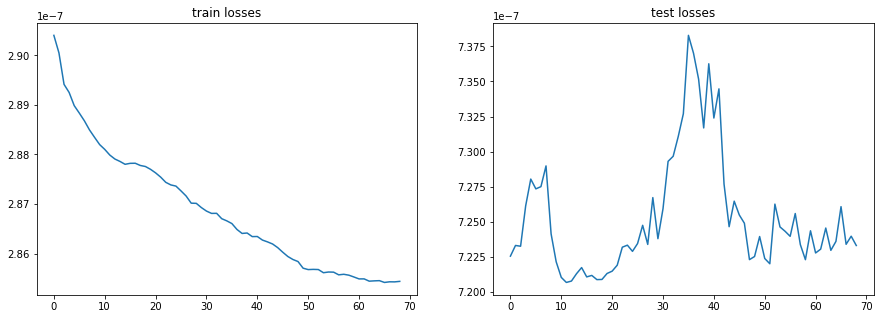

In [14]:
import matplotlib.pyplot as plt
f,ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(losses[1:])
ax[0].set_title('train losses')

ax[1].plot(val_losses[1:])
ax[1].set_title('test losses')
plt.show()

In [12]:
with open("scin_train.pkl", "wb") as fp:
    pickle.dump(losses,fp)
with open("scin_test.pkl", "wb") as fp:
    pickle.dump(val_losses, fp)

In [15]:
import torch.onnx
model.eval()
dummy_input = torch.randn(1,1,64).to(device)
torch_out = model(dummy_input)

torch.onnx.export(model, dummy_input, "SCIn.onnx", export_params=True,
                 do_constant_folding=True, input_names=['input'], output_names=['output'],
                 opset_version=9)

RuntimeError: step!=1 is currently not supported